# Are We Havin a Laugh?

Ever since Don voiced his thoughts on the use of 'haha' and its variants (last year in the kitchen in Talf I think) it's been on my mind that potentially the group has become more generous with their whatsapp laughter - which is nice. We all like to have a laugh with our mates and what better way than to chuck a 'haha' back on the chat when something tickles you.

Let's have a look at how the hypothesis pans out in the data.

I've grabbed the 4 chats I've been apart of - names refer to their current incarnation:
 - Videos of Worms (VoW): All the lads
 - Drama in the Surf Shack (DSS): Lads ex Nunhead-dwelling Roops
 - The Re-rack (RR): DSS + Ms Al Bunt
 - Chants Johnson (CJ): DSS minus Ed (lockdown 2 I believe)
 
I've exported, parsed n joined them to create one big table of all our 'banter'.

## 1. Import Data and Parse Into 'Nice' Format

The heavy lifting - gets everything nicely into a pd.DataFrame so can then easily analyse da bantaaa.

In [1]:
# imports and pesky warning suppression
import datetime as dt
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import string
from zipfile import ZipFile

import warnings

sns.set()
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', -1)

In [2]:
# convert whatsapp zip file to text
def extract_zip(input_zip):
    input_zip=ZipFile(input_zip)
    return {name: input_zip.read(name) for name in input_zip.namelist()}

In [3]:
# load in them convos
wa_vow = extract_zip('./data/WhatsApp Chat - Videos of worms.zip')
wa_dss = extract_zip('./data/WhatsApp Chat - Drama in the Surf Shack.zip')
wa_rr = extract_zip('./data/WhatsApp Chat - the re-rack.zip')
wa_cj = extract_zip('./data/WhatsApp Chat - Chants Johnson’s.zip')

In [4]:
# convert a str (one line of convo) into sub-components
def getDataPoint(line):
    splitLine = line.split('] ')
    dateTime = splitLine[0][1:] # dateTime = '18/06/17, 22:47'
    date, time = dateTime.split(', ') # date = '18/06/17'; time = '22:47'
    message = ' '.join(splitLine[1:])
    author = None
    
    if ":" in message:
        if startsWithAuthor(message): # True
            splitMessage = message.split(': ')
            author = splitMessage[0]
            message = ' '.join(splitMessage[1:])
    else:
        subM = message.split(' ')
        author = " ".join(subM[:2])
    return date, time, author, message

# checker if line starts with author and so is a valid message
def startsWithAuthor(s):
    patterns = [
        '([\w]+):',                        # First Name
        '([\w]+[\s]+[\w]+):',              # First Name + Last Name
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',    # First Name + Middle Name + Last Name
        '([+]\d{1} \(\d{3}\) \d{3}-\d{4}):', # ‪+1 (571) 324‑0857‬:
        '([+]\d{2} \d{3} \d{3} \d{4}):',   # Mobile Number (US)
        '([+]\d{2} \d{4} \d{7})'           # Mobile Number (Europe)
    ]
    pattern = '^' + '|'.join(patterns)
    result = re.match(pattern, s)
    if result or 'MacLachlan' in s:
        return True
    return False

# check if starts with a time
def startsWithDateTime(s):
    pattern = '^\[([0-2][0-9]|(3)[0-1])(\/)(((0)[0-9])|((1)[0-2]))(\/)(\d{2}|\d{4}), ([0-9][0-9]):([0-9][0-9]):([0-9][0-9])\]'
    result = re.match(pattern, s)
    if result or '\u200e' in s:
        return True
    return False

In [5]:
# initialise parsed data as an empty list (to be populated)
def parse_zip(wa_zip):
    
    parsed_data = []
    convo_list = wa_zip['_chat.txt'].decode('utf-8').split('\n')

    for line in convo_list:
        line = line.strip() # remove funny whitespaces
        line = line.replace("\u200e", "")
        if startsWithDateTime(line): # if starts with date time then we're good to go
            date, time, author, message = getDataPoint(line)
            parsed_data.append([date, time, author, message])
            
    return parsed_data

In [6]:
# create lists of date / time / author / message per group
vow = parse_zip(wa_vow)
dss = parse_zip(wa_dss)
rr = parse_zip(wa_rr)
cj = parse_zip(wa_cj)

# create dataframes from these
df_vow = pd.DataFrame(vow, columns=['Date', 'Time', 'Author', 'Message'])
df_dss = pd.DataFrame(dss, columns=['Date', 'Time', 'Author', 'Message'])
df_rr = pd.DataFrame(rr, columns=['Date', 'Time', 'Author', 'Message'])
df_cj = pd.DataFrame(cj, columns=['Date', 'Time', 'Author', 'Message'])

# create Group col - maybe hahas vary by group
df_vow['Group'] = 'vow'
df_dss['Group'] = 'dss'
df_rr['Group'] = 'rr'
df_cj['Group'] = 'cj'

# type format each df and drop NaNs
for df in [df_vow, df_dss, df_rr, df_cj]:
    # format them cols
    df['DateTime'] = df['Date'] + ' ' + df['Time']
    df['DateTime'] = pd.to_datetime(df['DateTime'], format='%d/%m/%Y %H:%M:%S')
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
    df.Time = pd.to_datetime(df.Time)
    df.Time = df.Time.apply(lambda x: x.time())
    df['Hour'] = df['Time'].apply(lambda x: x.hour)
    # check not dropping a load of messages
    print('Length of group: {},  un-dropped df is: {}'.format(df.Group.iloc[0], len(df)))
    df.dropna(inplace=True)
    print('Length of group: {},  dropped df is: {}'.format(df.Group.iloc[0], len(df)))

Length of group: vow,  un-dropped df is: 4910
Length of group: vow,  dropped df is: 4910
Length of group: dss,  un-dropped df is: 5659
Length of group: dss,  dropped df is: 5658
Length of group: rr,  un-dropped df is: 1017
Length of group: rr,  dropped df is: 1016
Length of group: cj,  un-dropped df is: 5283
Length of group: cj,  dropped df is: 5282


In [7]:
# bang them together, sort and create month-year col for time-wise grouping
df = pd.concat([df_vow, df_dss, df_rr, df_cj]).sort_values('DateTime')
df['Month'] = df['Date'].dt.strftime('%Y-%m')
df = df[df.Date > '2020-05']

In [309]:
df.tail()

,Date,Time,Author,Message,Group,DateTime,Hour,Month
4905,2021-02-23,08:32:40,Edward Maclachlan,Dom put the house account details down so roops can send,vow,2021-02-23 08:32:40,8,2021-02
4906,2021-02-23,08:33:02,Don Batten,same acct you used to pay rent into roop,vow,2021-02-23 08:33:02,8,2021-02
4907,2021-02-23,08:33:05,Don Batten,many moons ago,vow,2021-02-23 08:33:05,8,2021-02
4908,2021-02-23,08:33:20,Rupert Hill,Yer nice,vow,2021-02-23 08:33:20,8,2021-02
4909,2021-02-23,08:37:29,Joe Bourne,Don’t embezzle,vow,2021-02-23 08:37:29,8,2021-02


We now have all our data from May-2020 onwards (when I joined Talf and subsequently them whatsapp groups) in a nice tabular format (I *heart* dfs)

## 2. Brief Overview of Overall Messages

Before getting into the lolz, let's have a little overview of how the messaging history looks in general - partially to check for anomolies, partially because it's interesting.

### 2a. Whatsapp Activity Quite Correlated With Coronavirus Waves

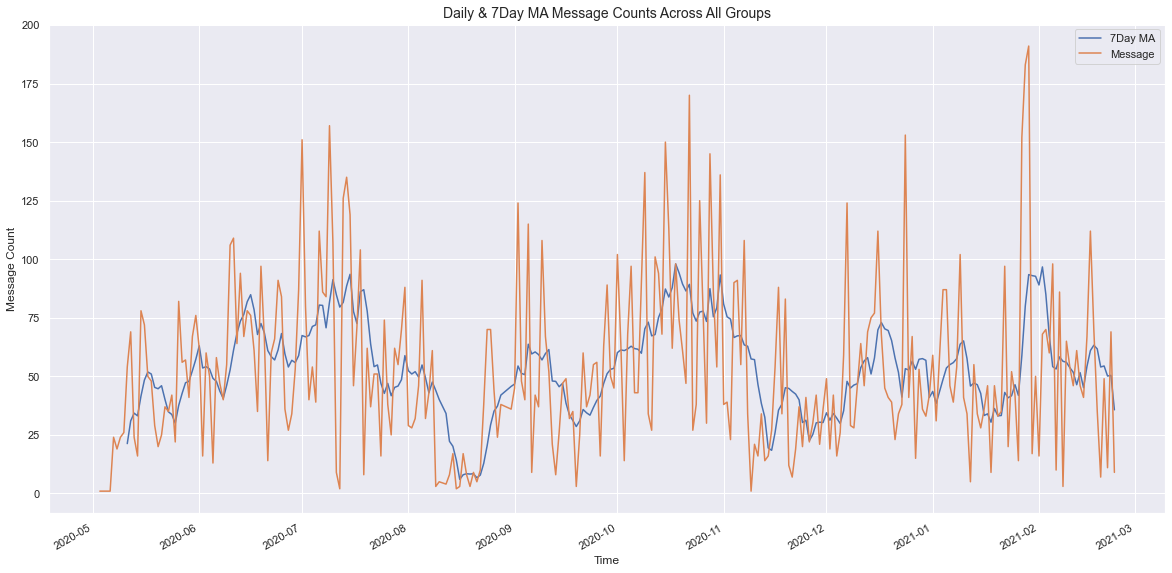

In [310]:
fig, ax = plt.subplots(figsize=(20,10))

df[['Message','Date']].groupby(['Date']).count().rename(columns={'Message': '7Day MA'}).rolling(7).mean().plot(ax=ax);
df[['Message','Date']].groupby(['Date']).count().plot(ax=ax);
ax.set_title('Daily & 7Day MA Message Counts Across All Groups', fontdict={'fontsize': 14})
ax.set_xlabel('Time')
ax.set_ylabel('Message Count');

This one seems like a positive point. It seems like __we like to talk to each other irl more than on whatsapp__. The big dipper in the middle of August last year is us jollying around Switzerland and Italy and the data reinforces the fact __we're actually quite good mates who like hanging out with each other__.

Activity then picks up again heading into November as restrictions ramp up and we get ourselves through with exchanging __'top quality banter'__ on the chat. Again, it tails off halfway through Nov as most of us are in Sagres and all working in the same room - __again, it seems we prefer to talk to each other irl.__

### 2b. Joe Bourne is the Glue That Binds Us

Not resting on his laurels, JB (purple) continues to contribute heavily - only being surpassed as the top contributer in 3 months:
 - 2x by Ed which is a stellar effort given he is in only 3 of 4 groups included
 - 1x by Me - most noteably when I was bored off my tits in Belfast last year

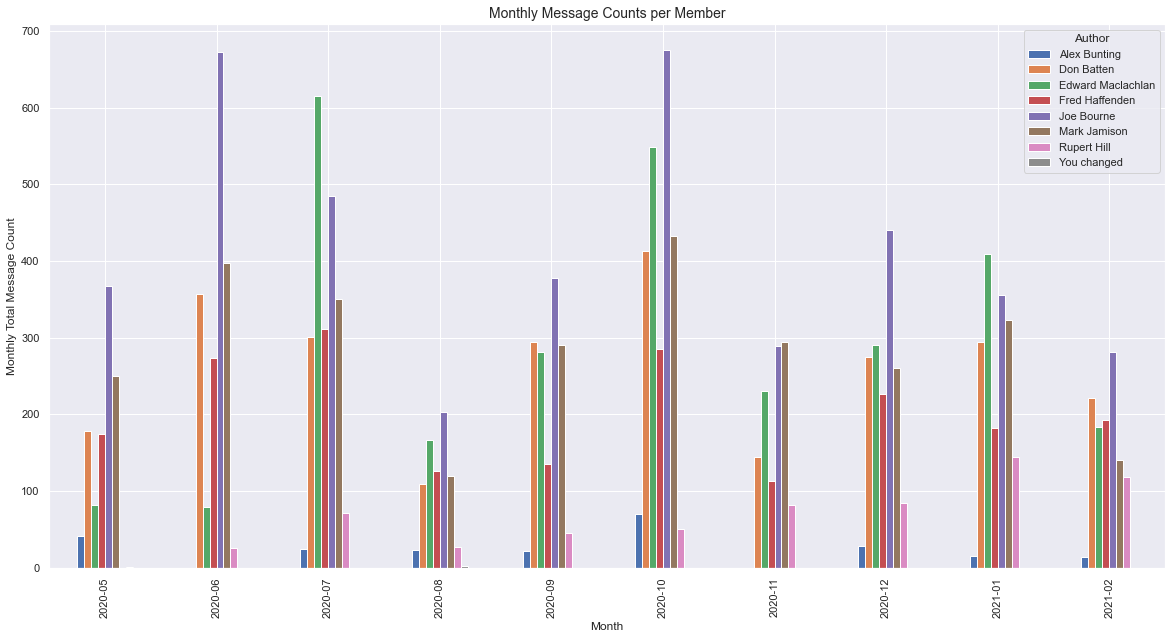

In [311]:
fig, ax = plt.subplots(figsize=(20,10))

pd.pivot_table(df[['Message','Month', 'Author']]
               .groupby(['Month', 'Author']).count(),
               columns='Author',
               index='Month',
               values='Message').plot(kind='bar', ax=ax)
ax.set_title('Monthly Message Counts per Member', fontdict={'fontsize': 14})
ax.set_xlabel('Month')
ax.set_ylabel('Monthly Total Message Count');

### 2c. Long Live the OG Group

Only a recent member, I have no claim on the long history of VoW and its previous incarnations. However, looking at the below (now that Talf is gone and we are sporadically housed) the other groups had their lockdown-induced moments in the sun, __but the OG is back.__

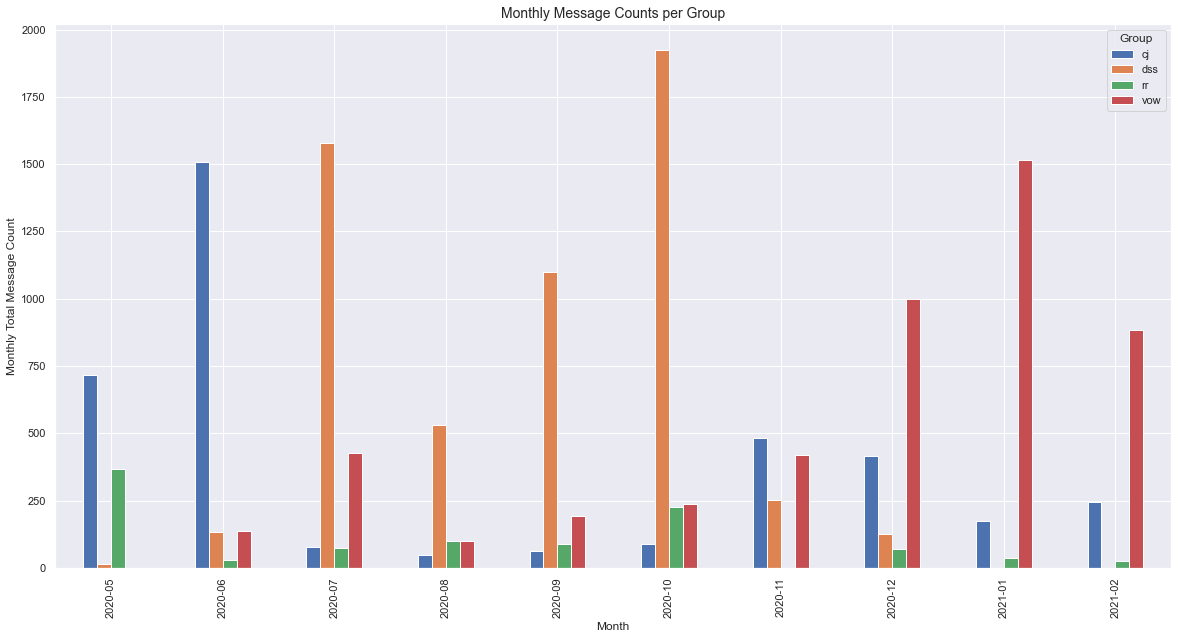

In [312]:
fig, ax = plt.subplots(figsize=(20,10))

pd.pivot_table(df[['Message','Month', 'Group']]
               .groupby(['Month', 'Group']).count(),
               columns='Group',
               index='Month',
               values='Message').plot(kind='bar', ax=ax)
ax.set_title('Monthly Message Counts per Group', fontdict={'fontsize': 14})
ax.set_xlabel('Month')
ax.set_ylabel('Monthly Total Message Count');

## 3. But What About Them Haha's? 

Now onto the core hypothesis - is there a trend with the doling out of haha's? First need to add a few more columns.

### 3a. Defining 'Laughter'

First we need to qualify what text qualifies as a 'laughter response'. For this, there appear to be 2 main variants:
 - 'haha variant': 'haha', 'hahah', 'hahaha' and even 'aha' and 'ahah'
 - 'lol variant': 'lol', 'lolol', 'llol' etc
 
We need to construct these word lists then apply a text search function to find messages containing them. Specifically:
 - Need to avoid words where a 'laugh variant' is a substring of a word e.g. 'ha' inside 'happen'
 - Try to minimise the search space of we will have to search $n$ messages for $m$ substrings which can become very slow

First we define the 'haha variant':

In [313]:
haha_list = []
max_haha_length = 10

# handle the haha variant
for i in range(2, max_laugh_length+1):
    # generate combinations
    haha_words = [''.join(x) for x in itertools.product(*(['ha'] * i))]
    # ensure both chars in
    haha_words = [x for x in haha_words if 'h' in x and 'a' in x]
    # remove 'surprise words' like 'ah' and 'ahhh'
    # defined as starting with a's and then not repeating
    for w in haha_words:
        # if starts with 'a'
        if 'a' == w[0]:
            # if following first 'h' there ain't another 'a'
            if 'a' not in w[w.find('h'):]:
                # remove
                haha_words.remove(w)
    
    haha_list.append(haha_words)
    
# flatten that list of lists to a depth=1 list of lol words
haha_list = [item for sublist in haha_list for item in sublist]
# need to reverse the lists to prevent 'haha' being detected as 'ha'
haha_list.reverse()
print("We now have a list of {:,} possible 'haha' words".format(len(haha_list)))

We now have a list of 1,981 possible 'haha' words


Now the lol variant (being careful to remove things like 'oll' which appear frequently in words:

In [314]:
lol_list = []
max_haha_length = 10
# avoid any other 3 letter iteration of chars 'ol'
# common in words like 'collect', 'holly' etc
lol_list.append(['lol'])

# handle the haha variant
for i in range(4, max_laugh_length+1):
    # generate combinations
    lol_words = [''.join(x) for x in itertools.product(*(['lo'] * i))]
    # ensure both chars in
    lol_words = [x for x in lol_words if 'l' in x and 'o' in x]
    lol_list.append(lol_words)
    
# flatten that list of lists to a depth=1 list of lol words
lol_list = [item for sublist in lol_list for item in sublist]
# need to reverse the lists to prevent 'lolol' being detected as 'lol'
lol_list.reverse()
print("We now have a list of {:,} possible 'lol' words".format(len(lol_list)))

We now have a list of 2,019 possible 'lol' words


And define a function to search for these substrings in the message strings, avoiding 'embedded laugh words':

In [315]:
def laugh_finder(mess, laugh_list):
    # only get laugh_list where elements are shorter than message length
    # you can't find 'hahahah' in a message with only 3 chars e.g. 'yes'
    poss_laughs = [x for x in laugh_list if len(x) <= len(mess)]
    mess = mess.lower()
    # now we iterate through and check if string contains word
    for word in poss_laughs:
        if word in mess:
            # if only 2 chars in message after stripping spaces
            # then only ha involved, so true
            if len(set(mess.replace(' ',''))) == 2:
                return [True, word]
            # else we need to remove e.g. 'ha' as part of another word
            # e.g. 'ha'ppen showing up
            mess_list = mess.split(' ')
            key_word = [x for x in mess_list if word in x]
            for kw in key_word:
                if len(set(kw)) == 2:
                    return [True, word]
    # else not found
    return [False, 'None']

We can now apply this function as a lambda function to our df and generate a few cols which we can use to generate charts

In [316]:
# apply these functions, plus create any laugh col
df[['ContainsHahaWord', 'HahaLaughWord']] = df['Message'].apply(lambda x: laugh_finder(x, haha_list)).to_list()
df[['ContainsLolWord', 'LolLaughWord']] = df['Message'].apply(lambda x: laugh_finder(x, lol_list)).to_list()
df['ContainsLaughWord'] = df[['ContainsHahaWord', 'ContainsLolWord']].any(axis=1)
df['ContainsBothLaughWord'] = df[['ContainsHahaWord', 'ContainsLolWord']].all(axis=1)

# define if only laugh word, or part of a larger message
df['OnlyHahaWord'] = (df['ContainsHahaWord'] & (df['Message'].str.split(' ').str.len() < 2))
df['OnlyLolWord'] = (df['ContainsLolWord'] & (df['Message'].str.split(' ').str.len() < 2))
df['OnlyLaughWord'] = (df['ContainsLaughWord'] & (df['Message'].str.split(' ').str.len() < 2))

df['LaughWord'] = np.where(df['HahaLaughWord'] != 'None', df['HahaLaughWord'], df['LolLaughWord'])

We now have our data ready to analyse.

### 3b. Laughter Matrices

So which words do we use the most to express a tittle? And does this change depending on whether or not the message has accompanying text?

#### 3bi. Messages only containing a 'laugh word' - no additional text

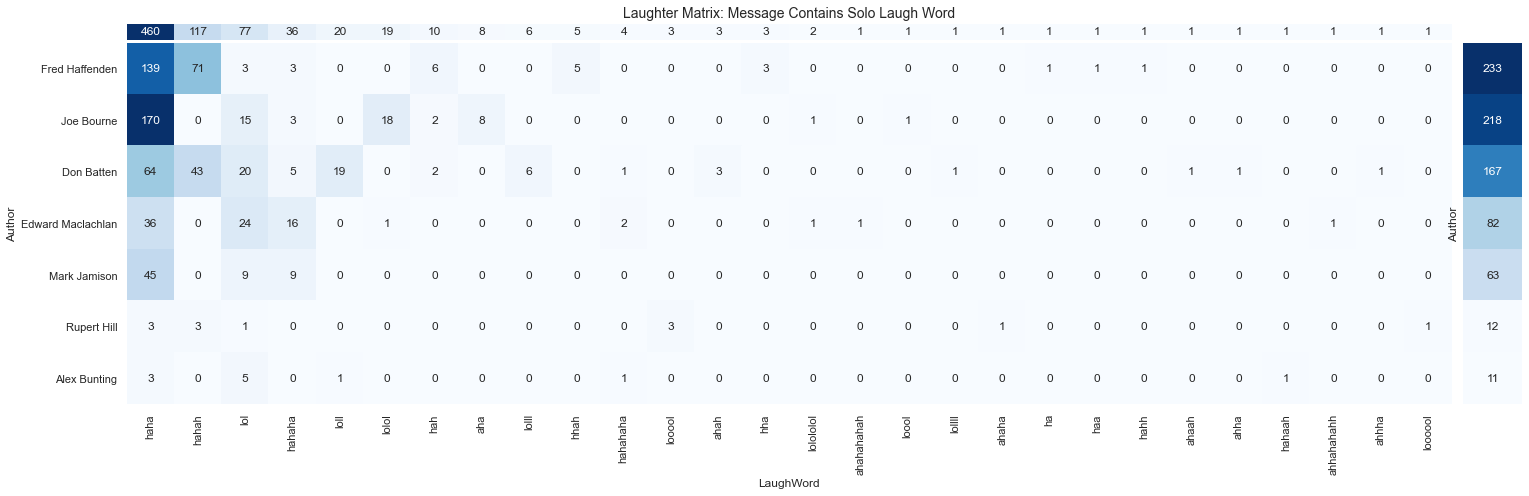

In [317]:
# amended/stripped from https://stackoverflow.com/questions/33379261/how-can-i-have-a-bar-next-to-python-seaborn-heatmap-which-shows-the-summation-of
# create heatmap with totals
fig = plt.figure(figsize=(25,7))
ax2 = plt.subplot2grid((20,20), (0,0), colspan=19, rowspan=1)
ax1 = plt.subplot2grid((20,20), (1,0), colspan=19, rowspan=19)
ax3 = plt.subplot2grid((20,20), (1,19), colspan=1, rowspan=19)

# create grid with rows and cols sorted (condenses colour in top left)
df_lm = pd.pivot_table(df[df.OnlyLaughWord][['Author', 'LaughWord', 'Message']]
                       .groupby(['Author', 'LaughWord']).count(),
                       columns='LaughWord',
                       index='Author',
                       values='Message').fillna(0)
df_lm = df_lm.loc[df_lm.sum(axis=1).sort_values(ascending=False).index][df_lm.sum().sort_values(ascending=False).index]

# plot the heatmap
sns.heatmap(df_lm,
            ax=ax1,
            cmap='Blues',
            annot=True,
            cbar=False,
            fmt=',.0f');
# plot the row totals on the far right
sns.heatmap(pd.DataFrame(df_lm.sum(axis=1)), ax=ax3,  annot=True, cmap="Blues", fmt=',.0f', cbar=False, xticklabels=False, yticklabels=False);
# plot the col totals on top with an accompanying title
sns.heatmap((pd.DataFrame(df_lm.sum(axis=0))).transpose(), ax=ax2,  annot=True, cmap="Blues", fmt=',.0f', cbar=False, xticklabels=False, yticklabels=False);
ax2.set_title('Laughter Matrix: Message Contains Solo Laugh Word', fontdict={'fontsize': 14});

Takeaways:
 - The lone 'haha' dominates as expected
 - Fred not only leads the way in laugh word only responses, but his constant struggle with spelling gives him considerable breadth in his replies
 - In comparison, I am a complete square when it comes to laughter responses with a narrow arsenal of 'haha', 'lol' and 'hahaha'
 - Dom and Ed both distribute their responses well - assessing the situation and responding with their chosen laugh word (in comparison to the 'haha'-heavy JB)
 - lol remains in use as a solo response despite potential exact synonymity with 'haha'
 - Rupert _provides_ banter, he doth not laugheth (although qualified by presence in only VoW)

#### 3bii. Messages with additional text

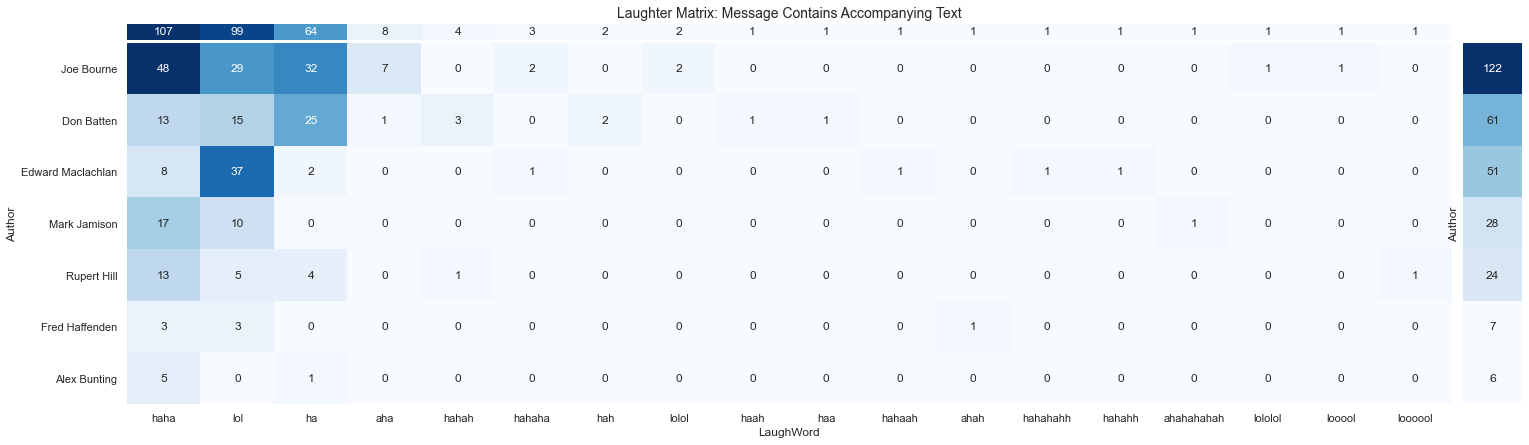

In [318]:
# amended/stripped from https://stackoverflow.com/questions/33379261/how-can-i-have-a-bar-next-to-python-seaborn-heatmap-which-shows-the-summation-of
# create heatmap with totals
fig = plt.figure(figsize=(25,7))
ax2 = plt.subplot2grid((20,20), (0,0), colspan=19, rowspan=1)
ax1 = plt.subplot2grid((20,20), (1,0), colspan=19, rowspan=19)
ax3 = plt.subplot2grid((20,20), (1,19), colspan=1, rowspan=19)

# create grid with rows and cols sorted (condenses colour in top left)
df_lm = pd.pivot_table(df[df.ContainsLaughWord & ~df.OnlyLaughWord][['Author', 'LaughWord', 'Message']]
                       .groupby(['Author', 'LaughWord']).count(),
                       columns='LaughWord',
                       index='Author',
                       values='Message').fillna(0)
df_lm = df_lm.loc[df_lm.sum(axis=1).sort_values(ascending=False).index][df_lm.sum().sort_values(ascending=False).index]

# plot the heatmap
sns.heatmap(df_lm,
            ax=ax1,
            cmap='Blues',
            annot=True,
            cbar=False,
            fmt=',.0f');
# plot the row totals on the far right
sns.heatmap(pd.DataFrame(df_lm.sum(axis=1)), ax=ax3,  annot=True, cmap="Blues", fmt=',.0f', cbar=False, xticklabels=False, yticklabels=False);
# plot the col totals on top with an accompanying title
sns.heatmap((pd.DataFrame(df_lm.sum(axis=0))).transpose(), ax=ax2,  annot=True, cmap="Blues", fmt=',.0f', cbar=False, xticklabels=False, yticklabels=False);
ax2.set_title('Laughter Matrix: Message Contains Accompanying Text', fontdict={'fontsize': 14});

Takeaways:
 - A much higher concentration of laugh responses, with noteably 'ha' entering the mix when dormant as a single word response
 - JB surges to the top here - __he appreciates the banter, but he doth then respond__
 - 'lol' and 'haha' both vie for top spot here, with the use of 'lol' in its ironic form _potentially_ bringing it to the fore

#### 3biii. All messages containing a laugh word

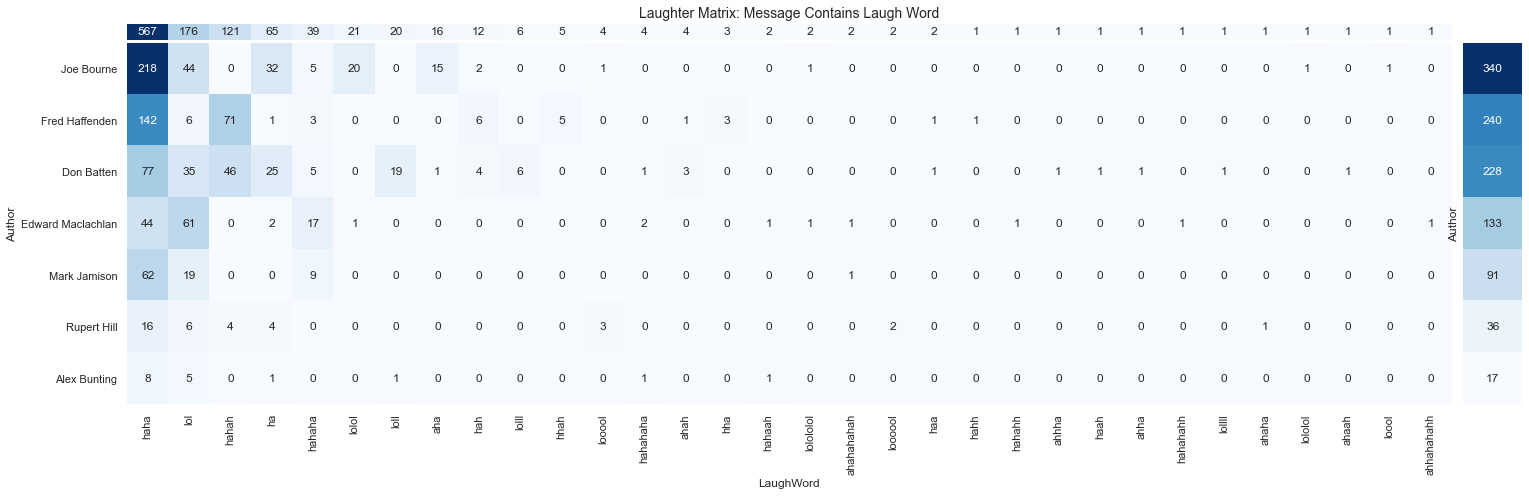

In [319]:
# amended/stripped from https://stackoverflow.com/questions/33379261/how-can-i-have-a-bar-next-to-python-seaborn-heatmap-which-shows-the-summation-of
# create heatmap with totals
fig = plt.figure(figsize=(25,7))
ax2 = plt.subplot2grid((20,20), (0,0), colspan=19, rowspan=1)
ax1 = plt.subplot2grid((20,20), (1,0), colspan=19, rowspan=19)
ax3 = plt.subplot2grid((20,20), (1,19), colspan=1, rowspan=19)

# create grid with rows and cols sorted (condenses colour in top left)
df_lm = pd.pivot_table(df[df.ContainsLaughWord][['Author', 'LaughWord', 'Message']]
                       .groupby(['Author', 'LaughWord']).count(),
                       columns='LaughWord',
                       index='Author',
                       values='Message').fillna(0)
df_lm = df_lm.loc[df_lm.sum(axis=1).sort_values(ascending=False).index][df_lm.sum().sort_values(ascending=False).index]

# plot the heatmap
sns.heatmap(df_lm,
            ax=ax1,
            cmap='Blues',
            annot=True,
            cbar=False,
            fmt=',.0f');
# plot the row totals on the far right
sns.heatmap(pd.DataFrame(df_lm.sum(axis=1)), ax=ax3,  annot=True, cmap="Blues", fmt=',.0f', cbar=False, xticklabels=False, yticklabels=False);
# plot the col totals on top with an accompanying title
sns.heatmap((pd.DataFrame(df_lm.sum(axis=0))).transpose(), ax=ax2,  annot=True, cmap="Blues", fmt=',.0f', cbar=False, xticklabels=False, yticklabels=False);
ax2.set_title('Laughter Matrix: Message Contains Laugh Word', fontdict={'fontsize': 14});

__All in this means that JB reigns supreme for providing those laughter responses__

#### 3biv. All messages containing a laugh word, normalised by total message count

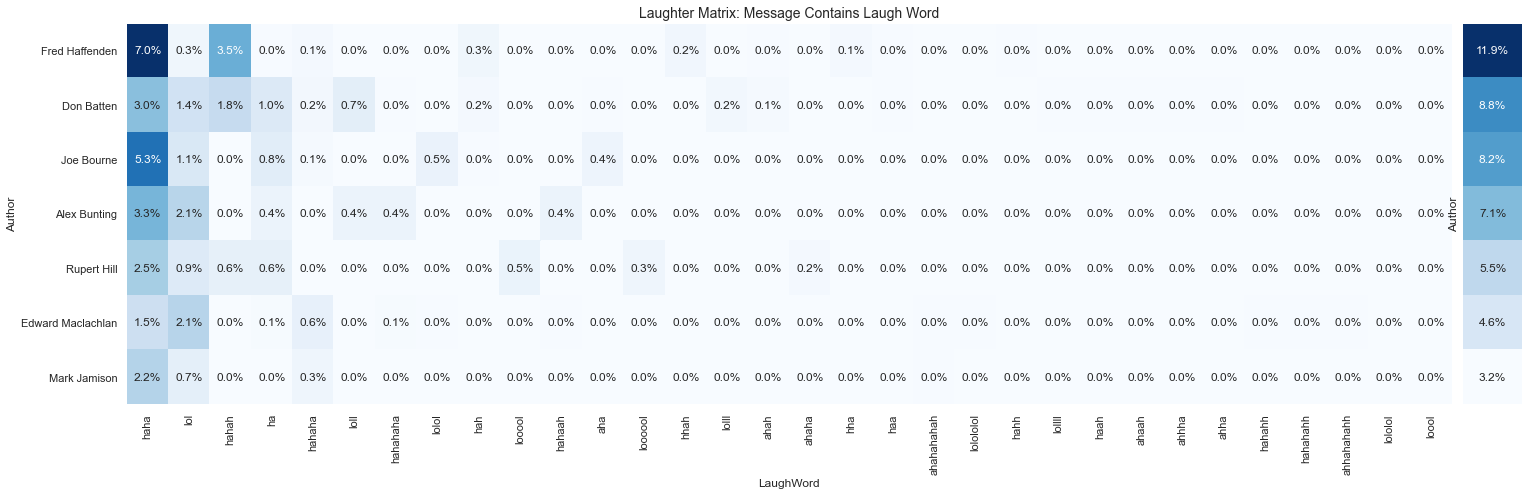

In [330]:
# amended/stripped from https://stackoverflow.com/questions/33379261/how-can-i-have-a-bar-next-to-python-seaborn-heatmap-which-shows-the-summation-of
# create heatmap with totals
fig = plt.figure(figsize=(25,7))
ax1 = plt.subplot2grid((20,20), (0,0), colspan=19, rowspan=20)
ax2 = plt.subplot2grid((20,20), (0,19), colspan=1, rowspan=20)

# create grid with rows and cols sorted (condenses colour in top left)
df_lmp = pd.pivot_table(df[df.ContainsLaughWord][['Author', 'LaughWord', 'Message']]
                       .groupby(['Author', 'LaughWord']).count() / 
                        df[['Author', 'Message']]
                       .groupby(['Author']).count(),
                       columns='LaughWord',
                       index='Author',
                       values='Message').fillna(0)
df_lmp = df_lmp.loc[df_lmp.sum(axis=1).sort_values(ascending=False).index][df_lmp.sum().sort_values(ascending=False).index]

# plot the heatmap
sns.heatmap(df_lmp,
            ax=ax1,
            cmap='Blues',
            annot=True,
            cbar=False,
            fmt='.1%');
ax1.set_title('Laughter Matrix: % Of All Messages Contains Laugh Word', fontdict={'fontsize': 14});
# plot the row totals on the far right
sns.heatmap(pd.DataFrame(df_lmp.sum(axis=1)), ax=ax2,  annot=True, cmap="Blues", fmt='.1%', cbar=False, xticklabels=False, yticklabels=False);

Given Joe is consistently the overall top contributer, once normalising the laughs he doles out by the his overall message count, this brings him back to the middle of the table. Fred's relative overall lack of activity gives him a considerable lead at the top. __And even more so than before I remain a miserable bastard bringing up the rear.__

### 3c. Message Count Adjusted, Are We Laughing More Now?

Time to check the trend - once we account for the overall number of messages - are we dolling out more haha's and the likes now?

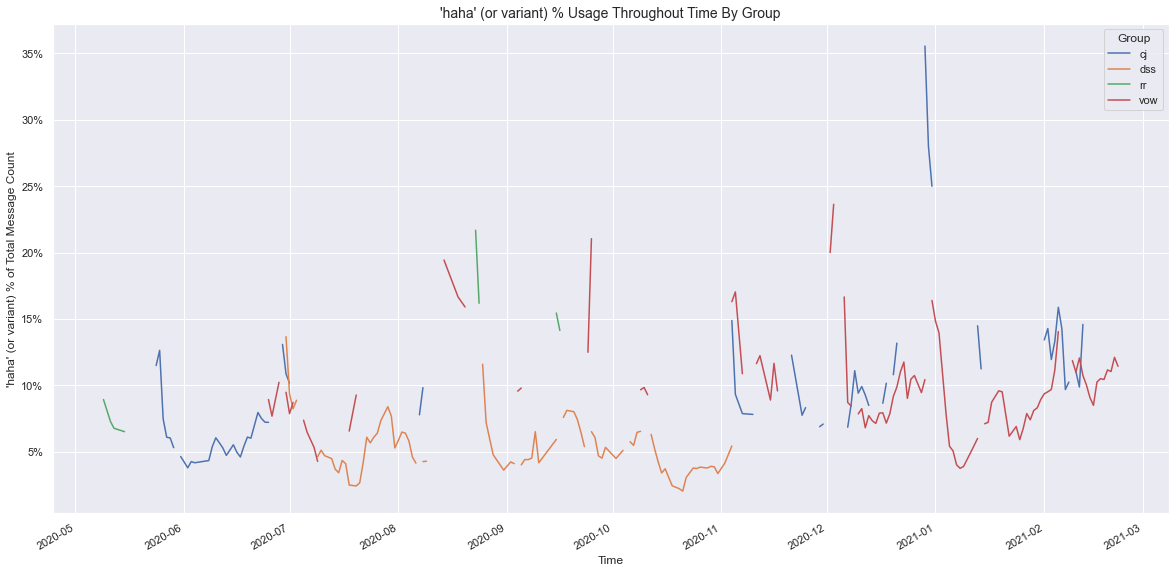

In [531]:
fig, ax = plt.subplots(figsize=(20,10));
pd.pivot_table((df[df.OnlyLaughWord][['Date', 'Group', 'Message']]
              .groupby(['Group', 'Date']).count().fillna(0).rolling(7).mean() /
              df[['Date', 'Group', 'Message']]
              .groupby(['Group', 'Date']).count().fillna(0).rolling(7).mean()),
               columns='Group',
               index='Date',
               values='Message').plot(ax=ax)

ax.set_title("'haha' (or variant) % Usage Throughout Time By Group", fontdict={'fontsize': 14});
ax.set_xlabel('Time')
ax.set_ylabel("'haha' (or variant) % of Total Message Count")
ax.set_yticklabels(['{:,}'.format(int(x*100))+'%' for x in ax.get_yticks().tolist()]);

The data is patchy and volatile - percentages are oft more volatile than the underlying series but:
 - Either:
  - something eff-in funny went down on Chant's Johnson at the end of 2020
  - there were very few messages
  - we were spending time with families and droppin 'hahas' on the chat sporadically
 - __Laughter is on the rise, buy while you still can!!!__: VoW has just surged past 10% of messages being a sole laughter response
 - We need to analyse the _overall laughter_ to help paint the picture

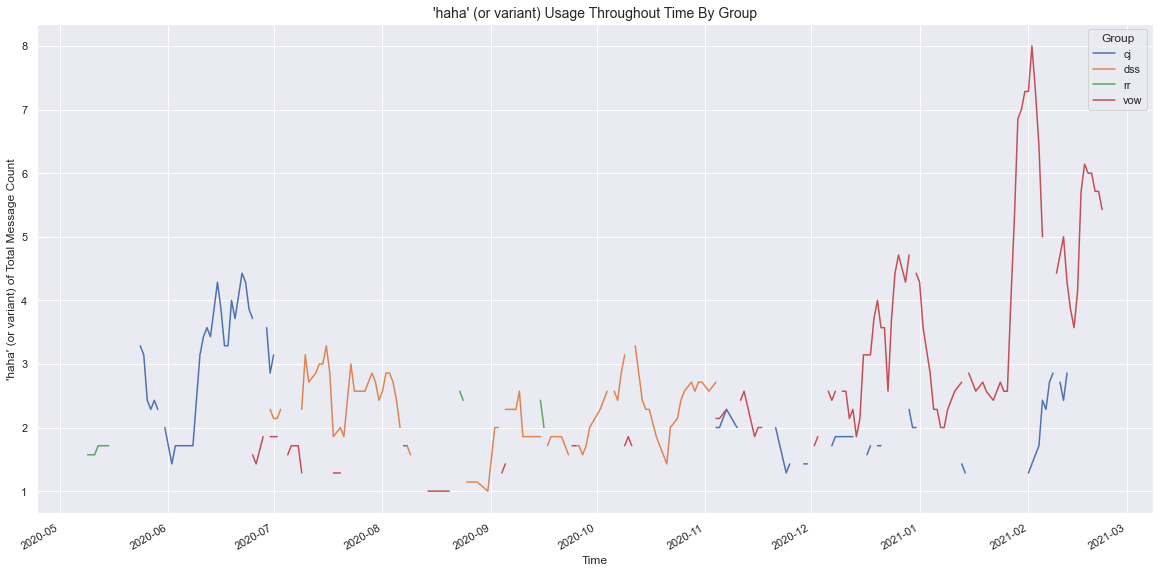

In [532]:
fig, ax = plt.subplots(figsize=(20,10));
pd.pivot_table(df[df.OnlyLaughWord][['Date', 'Group', 'Message']]
              .groupby(['Group', 'Date']).count().fillna(0).rolling(7).mean(),
               columns='Group',
               index='Date',
               values='Message').plot(ax=ax)

ax.set_title("'haha' (or variant) Usage Throughout Time By Group", fontdict={'fontsize': 14});
ax.set_xlabel('Time')
ax.set_ylabel("'haha' (or variant) of Total Message Count");

Contrasting to the overall message trends in 2a. (wave-like, similar to corona), __laughter has certainly increased in the last few months. Long may it continue.__

But _who_ is driving this rise in laughter-only filled responses? Let's dive in and look at the individual performances:

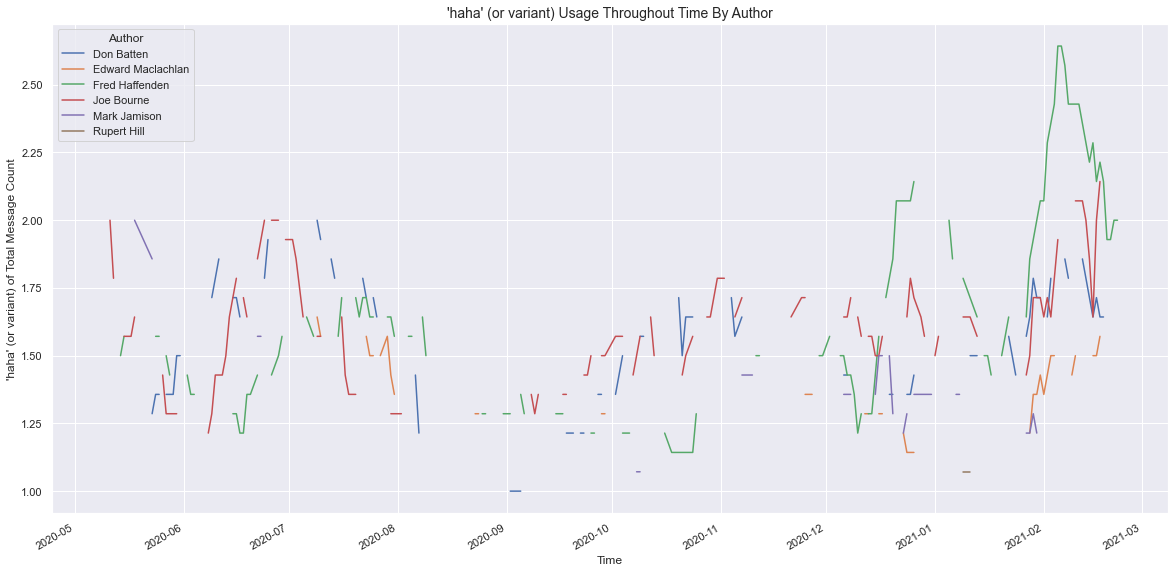

In [538]:
fig, ax = plt.subplots(figsize=(20,10));
pd.pivot_table(df[df.OnlyLaughWord][['Date', 'Author', 'Message']]
              .groupby(['Author', 'Date']).count().fillna(0).rolling(14).mean(),
               columns='Author',
               index='Date',
               values='Message').plot(ax=ax)

ax.set_title("'haha' (or variant) Usage Throughout Time By Author", fontdict={'fontsize': 14});
ax.set_xlabel('Time')
ax.set_ylabel("'haha' (or variant) of Total Message Count");

__We all are!!!__ Fred experiences extreme volatility but on the whole we are all chipping in.

Diving in now and viewing word counts we can check up on how (similar to corona again) our laughter variants perform - let's restrict to the top 5.

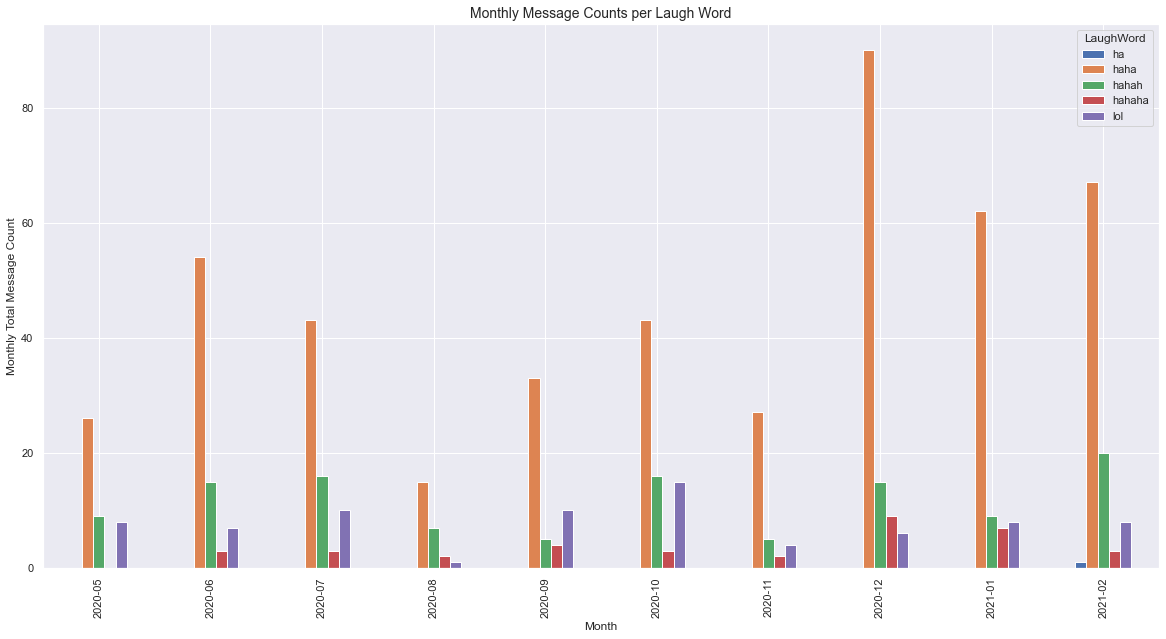

In [533]:
top_laugh_words = df[df.ContainsLaughWord][['LaughWord', 'Message']].groupby(['LaughWord']).count().sort_values('Message', ascending=False).head().index.values

fig, ax = plt.subplots(figsize=(20,10))
pd.pivot_table(df[(df.OnlyLaughWord) & (df.LaughWord.isin(top_laugh_words))][['Message', 'Month', 'LaughWord']]
               .groupby(['Month', 'LaughWord']).count(),
               columns='LaughWord',
               index='Month',
               values='Message').plot(kind='bar', ax=ax)
ax.set_title('Monthly Message Counts per Laugh Word', fontdict={'fontsize': 14})
ax.set_xlabel('Month')
ax.set_ylabel('Monthly Total Message Count');

Not much to say here apart from that 'haha' reigns supreme. Potentially 'hahah' is the new 'haha' for 2021 but:
 - the data is just _too inconclusive_
 - it's still a long way of reaching the lofty heights of 60 occurances per month - unless we collectively become a bit funnier 

## 4. Concluding Remarks / What Comes Next?

So, it appears our hypothesis _cannot_ be rejected and we do indeed seem to be being more generous with our laughter. Wot an effin nice bunch of guys we must be becoming. However, 'haha' / variants are not necessarily the sole objective - future work would investigate:
 - is there something fundamentally different about the message structure of a message containing laughter?
 - is there something fundamentally different about the way laughter-containing messages cluster through time/message space?

## 5. Appendix

In [540]:
df.to_csv('./data/wa_df.csv', index=False)

Graph showing % of authors' total messages made up of messages containing a laugh word - Fred peaking with sometimes 50% of messages laughter-inclusive!

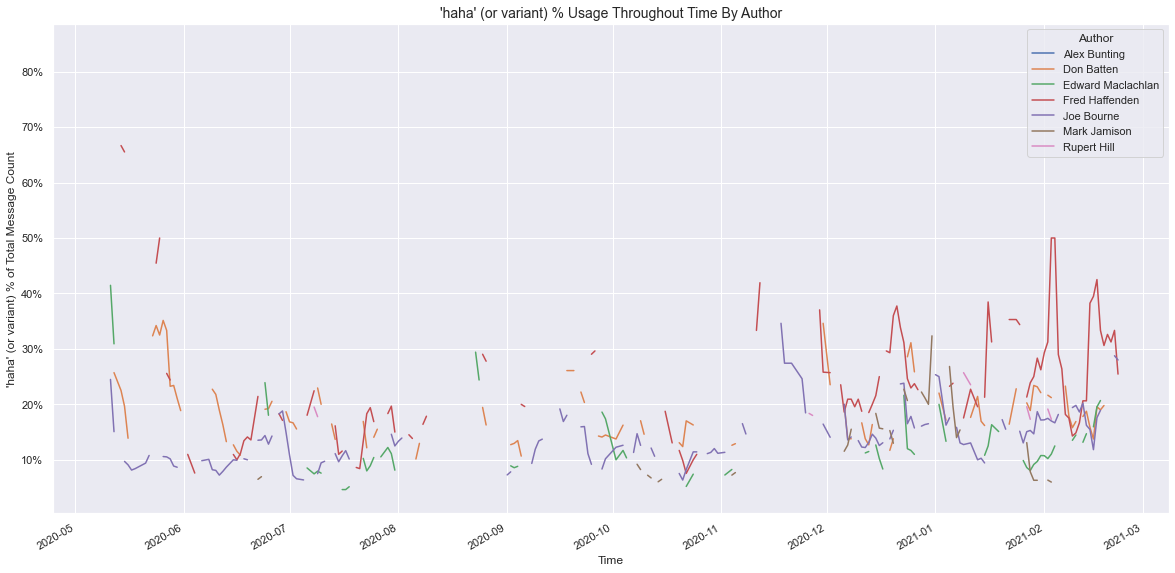

In [539]:
fig, ax = plt.subplots(figsize=(20,10));
pd.pivot_table((df[df.ContainsLaughWord][['Date', 'Author', 'Message']]
              .groupby(['Author', 'Date']).count().fillna(0).rolling(7).mean() /
              df[['Date', 'Author', 'Message']]
              .groupby(['Author', 'Date']).count().fillna(0).rolling(7).mean()),
               columns='Author',
               index='Date',
               values='Message').plot(ax=ax)

ax.set_title("'haha' (or variant) % Usage Throughout Time By Author", fontdict={'fontsize': 14});
ax.set_xlabel('Time')
ax.set_ylabel("'haha' (or variant) % of Total Message Count")
ax.set_yticklabels(['{:,}'.format(int(x*100))+'%' for x in ax.get_yticks().tolist()]);